<a href="https://colab.research.google.com/github/bigsword2064/Notebookpic/blob/master/cytoplasm_optical_tweezers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
FEniCS code for optical tweezers in cytoplasm.

- With the model comprising:
    > Large deformation Fung hyper-elasticity
    > Near incompressibility via a (u,p) split approach.
    > Finite deformation viscoelasticity through a generalized Maxwell
      model with 2 branches, with evolution of internal variables in the
      style of Green and Tobolsky (1946) and Linder et al. (2011).
    > Phase-field damage evolution in the viscoelastic networks only,
        which heals over time.

- Basic units:
    > Length: um
    >   Time: s
    >   Mass: mg

- Derived units:
    >             Force: pN
    >          Pressure: Pa


     Eric M. Stewart   and   Haiqian Yang    and   Thomas Henzel
   (ericstew@mit.edu)      (hqyang@mit.edu)       (henzel@mit.edu)

                             Spring 2023
"""

'\nFEniCS code for optical tweezers in cytoplasm.\n\n- With the model comprising:\n    > Large deformation Fung hyper-elasticity\n    > Near incompressibility via a (u,p) split approach.\n    > Finite deformation viscoelasticity through a generalized Maxwell\n      model with 2 branches, with evolution of internal variables in the\n      style of Green and Tobolsky (1946) and Linder et al. (2011).\n    > Phase-field damage evolution in the viscoelastic networks only,\n        which heals over time.\n\n- Basic units:\n    > Length: um\n    >   Time: s\n    >   Mass: mg\n\n- Derived units:\n    >             Force: pN\n    >          Pressure: Pa\n\n\n     Eric M. Stewart   and   Haiqian Yang    and   Thomas Henzel\n   (ericstew@mit.edu)      (hqyang@mit.edu)       (henzel@mit.edu)\n\n                             Spring 2023\n'

In [5]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

!wget https://www.dropbox.com/s/6dcvrsd2lx9ll4n/bead_cyl_fine.h5?dl=0 --content-disposition
!wget https://www.dropbox.com/s/w59wjwousuw2x91/bead_cyl_fine.xdmf?dl=0 --content-disposition

--2024-12-18 18:39:33--  https://www.dropbox.com/s/6dcvrsd2lx9ll4n/bead_cyl_fine.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/91ozg6d3ymzvq9kdb7cr1/bead_cyl_fine.h5?rlkey=l4f61b6mxrcjep9idqjxjdpnt&dl=0 [following]
--2024-12-18 18:39:33--  https://www.dropbox.com/scl/fi/91ozg6d3ymzvq9kdb7cr1/bead_cyl_fine.h5?rlkey=l4f61b6mxrcjep9idqjxjdpnt&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc17825d15d29d35f31a0ea5077d.dl.dropboxusercontent.com/cd/0/inline/CghiiXF6VAenqjROEqIh7G3wtjQzzT2bQKrr1JeM_Y699TzagjVOHwYgXzeDfha8yLy8tAZIbZ7orMySKZiWpHqMZ7Vh5VKggXOcnKbQ6ciA8Z9zD2_R5QwrAJvKX3cYasuSjsDOhqePw3vEZMpEWKoi/file# [following]
--2024-12-18 18:39:34--  https://uc17825d15d29d35f31a0ea5077d.dl.dropboxus

In [6]:
# FEniCS and FEniCS-related packages
from dolfin import *
import math
import numpy as np
import matplotlib.pyplot as plt
plt.close('all') # clear any plots from previous simulation.
from datetime import datetime

'''''''''''''''''''''
Parameters
'''''''''''''''''''''
# Hyperelasticity parameters
Gshear  = Constant(0.8)  # Shear modulus, Pa
#Gshear  = Constant(0.0)  # (un-comment this line to see secondary networks only)
stiffen = Constant(50.0)  # nonlinear stiffening parameter 50
Kbulk   = Constant(1e3)  # Bulk modulus, Pa

# Viscoelasticity parameters
Gneq_1  = Constant(3.0)    #  Non-equilibrium shear modulus, Pa
tau_1   = Constant(4.0)      #  relaxation time, s

Gneq_2  = Constant(3.0)    #  Non-equilibrium shear modulus, Pa
tau_2   = Constant(0.1)        #  relaxation time, s

# Damage parameters
zeta       = Constant(0.0003) # 0.0002
tau_h      = Constant(200)
heal       = Constant(zeta/tau_h)
psiStar    = Constant(1) # energy density of process zone, Pa
ell        = Constant(np.sqrt(10))  # length scale, um
grad_const = Constant(psiStar*ell*ell) # combined damage gradient parameter

# Simulation setup parameters
length        = 10.
width         = 10.
bead_radius   = 0.5  # um
disp_tot      = 0.8  # um
bead_velocity = 1.0  # um/s
Ncycle        = 3
numSteps      = 300  # integer number of steps

# Set level of detail for log messages (integer)
#
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
set_log_level(50)

# The behavior of the form compiler FFC can be adjusted by prescribing
# various parameters. Here, we want to use the UFLACS backend of FFC::
# Optimization options for the form compiler
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"
parameters["form_compiler"]["quadrature_degree"] = 2

'''''''''''''''''''''
DEFINE GEOMETRY
'''''''''''''''''''''

mesh = Mesh()
with XDMFFile("bead_cyl_fine.xdmf") as infile:
    infile.read(mesh)

# mesh = Mesh()
# with XDMFFile("bead_cyl_coarse.xdmf") as infile:
#      infile.read(mesh)

#import mshr
#domain = mshr.Rectangle(Point(0, -length), Point(length, length))-mshr.Circle(Point(0,0), bead_radius, 50)
#mesh = mshr.generate_mesh(domain,10)

# This says "spatial coordinates" but is really the referential coordinates,
# since the mesh does not convect in FEniCS.
x = SpatialCoordinate(mesh)

#Pick up on the boundary entities of the created mesh
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return math.isclose(x[0],length,abs_tol = 0.1) and on_boundary
class bead(SubDomain):
    def inside(self, x, on_boundary):
        return math.isclose(x[0]**2+x[1]**2, bead_radius**2, abs_tol = 0.01) and on_boundary

# Mark boundary subdomains
facets = MeshFunction("size_t", mesh, 1)
# facets.set_all(0)
DomainBoundary().mark(facets, 1)  # First, mark all boundaries with common index
# Next mark specific boundaries
Right().mark(facets,3)
bead().mark(facets, 6)

# Define the boundary integration measure "ds".
ds = Measure('ds', domain=mesh, subdomain_data=facets)

'''''''''''''''''''''''''''''''''''''''
MODEL & SIMULATION PARAMETERS
'''''''''''''''''''''''''''''''''''''''

# Visco dissipation switch, 0=dissipative,  1=lossless
disableDissipation = Constant(0.0)
#
# When enabled, this switch sets the relaxation times arbitrarily high,
# so that the instantaneous stiffness remains about the same but no energy
# is dissipated because the tensor variables A_i are constant.

# Set relaxation times arbitrarily high if visco is off
tau_1 = tau_1 + disableDissipation/DOLFIN_EPS
tau_2 = tau_2 + disableDissipation/DOLFIN_EPS

############# #################### ###############################################

# Simulation time control-related params
t        = 0.0       # start time
Ttot     = 2*Ncycle*disp_tot/bead_velocity    # total simulation time
dt       = Constant(Ttot/numSteps)   # (fixed) step size


funcstring = "2*disp_tot*abs(Ncycle*t/Ttot - floor(Ncycle*t/Ttot + 0.5))"
beadDisp = Expression(funcstring,
                    disp_tot = disp_tot,t = 0.0, Ttot=Ttot, Ncycle=Ncycle, degree=1)

'''''''''''''''''''''
FEM SETUP
'''''''''''''''''''''

# Define function space, both vectorial and scalar
U2 = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
T1 = TensorElement("Lagrange", mesh.ufl_cell(), 2, shape=(3, 3), symmetry =True) # tensor internal variable
ELEMENT = MixedElement([U2, P1, P1])               # mixed element
ME = FunctionSpace(mesh, ELEMENT) # Total space for all DOFs

W2 = FunctionSpace(mesh, U2) # Vector space for visulization later
W = FunctionSpace(mesh,P1)   # Scalar space for visulization later


# Define test functions in weak form
w_test = TestFunction(ME)   # Test function
(u_test, p_test, damage_test) = split(w_test)   # test fields

# Define actual functions with the required DOFs
w = Function(ME)
(u, p, damage) = split(w)        # actual fields

dw = TrialFunction(ME) # Trial functions used for automatic differentiation

# A copy of functions to store values in last step for time-stepping.
w_old = Function(ME)
(u_old, p_old, damage_old) = split(w_old)   # old fields

# ############ Initialization of the internal variables
#

# Create internal variables for viscous tensors
T1_state = FunctionSpace(mesh, T1)
A1_old = Function(T1_state)
A2_old = Function(T1_state)
#
A1 = Function(T1_state)
A2 = Function(T1_state)

# Assign identity as initial value for the viscous tensors
A1_old.assign(project(Identity(3), T1_state))
A2_old.assign(project(Identity(3), T1_state))

A1.assign(project(Identity(3), T1_state))
A2.assign(project(Identity(3), T1_state))

# internal variables for damage field
damage_state = FunctionSpace(mesh, P1)
damage_old = Function(damage_state)

damage_init = Constant(0.0)
damage_old.assign(project(damage_init, damage_state))



'''''''''''''''''''''
SUBROUTINES
'''''''''''''''''''''

# Special gradient operators for Axisymmetric formulation
#
# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def ax_grad_scalar(y):
    grad_y = grad(y)
    return as_vector([grad_y[0], grad_y[1], 0.])
#
# Gradient of vector field u
def ax_grad_vector(u):
    grad_u = grad(u)
    return as_tensor([[grad_u[0,0], grad_u[0,1], 0],
                  [grad_u[1,0], grad_u[1,1], 0],
                  [0, 0, u[0]/x[0]]])


# Axisymmetric deformation gradient
def F_ax_calc(u):
    dim = len(u)
    Id = Identity(dim)          # Identity tensor
    F = Id + grad(u)            # 2D Deformation gradient
    F33 = (x[0]+u[0])/x[0]      # axisymmetric F33, R/R0
    return as_tensor([[F[0,0], F[0,1], 0],
                  [F[1,0], F[1,1], 0],
                  [0, 0, F33]]) # Full axisymmetric F

def ax_traction(P,n):
    traction1=P[0,0]*n[0]+P[0,1]*n[1]
    traction2=P[1,0]*n[0]+P[1,1]*n[1]
    return as_vector([traction1, traction2, 0.])

def Max(a, b): return (a+b+abs(a-b))/Constant(2)
def Min(a, b): return (a+b-abs(a-b))/Constant(2)

def update_damage(damage_est):
    return Max(damage_est,0.0)

# function to write results fields to XDMF at time t
def writeResults(t):

        # Variable casting and renaming
        _w_1, _w_2, _w_3 = w.split()
        _w_1a,_w_1b = _w_1.split()

        # Deformation
        _w_1.rename("disp", "Displacement")

        # Project damage field  for visualization.
        damage_Viz = project(damage_old,W)
        damage_Viz.rename("Damage","Damage")

        # Project pressure-like field as well.
        p_Vis = -_w_2
        p_Viz = project(p_Vis,W)
        p_Viz.rename("pressure","Pressure")

        # Write field quantities of interest
        file_results.write(_w_1, t)
        file_results.write(damage_Viz, t)
        file_results.write(p_Viz, t)

# Slightly faster projection function for linear fields
# Based on Jermey Bleyer's function of the same name, cf. e.g.
# https://gitlab.enpc.fr/jeremy.bleyer/comet-fenics/-/blob/1028fd8438e2b23a69ae78d7d46ec810a5b8e3da/examples/nonlinear_materials/vonMises_plasticity.py.rst
#
def local_project(v, V, u=None):
    if V.ufl_element().degree() ==1:
        dv = TrialFunction(V)
        v_ = TestFunction(V)
        a_proj = inner(dv, v_)*dx
        b_proj = inner(v, v_)*dx
        Lsolver = LocalSolver(a_proj, b_proj)
        Lsolver.factorize
        if u is None:
            u = Function(V)
            Lsolver.solve_local_rhs(u)
            return u
        else:
            Lsolver.solve_local_rhs(u)
            return
    else:
        u = project(v,V)
        return u


'''''''''''''''''''''''''''''
KINEMATICS
'''''''''''''''''''''''''''''


# Deformation measures
F_3D = variable(F_ax_calc(u))
C_3D = variable(F_3D.T*F_3D)
Eg_3D= 0.5*(C_3D-Identity(3))
Cdis_3D = det(C_3D)**(-1/3)*C_3D

# Invariants
I1 = tr(Cdis_3D)
I2 = 0.5*(I1**2.0 - tr(Cdis_3D*Cdis_3D))
J  = det(C_3D)**(0.5)

# Discretized evolution equations for "viscous strain" tensors
A1 = (1/(1+dt/tau_1))*(A1_old + (dt/tau_1)*inv(Cdis_3D))
A2 = (1/(1+dt/tau_2))*(A2_old + (dt/tau_2)*inv(Cdis_3D))


'''''''''''''''''''''''''''''
CONSTITUTIVE RELATIONS
'''''''''''''''''''''''''''''

# Fung free energy density
psieq = Gshear/2/stiffen*exp(stiffen*(I1-3)) + p*(J-1.0) - (1.0/2.0/Kbulk)*p**2.0

# Add in the "non-equilibrium" viscoelasticity terms
#
psineq_1  = 0.5*Gneq_1*( (inner(A1,Cdis_3D) - 3.0) -ln(det(A1)))
#
psineq_2  = 0.5*Gneq_2*( (inner(A2,Cdis_3D) - 3.0) -ln(det(A2)))

# Total energy
psi  =  psieq + (psineq_1 + psineq_2)*exp(-damage_old)

# Calculate 1st PK stress
P = 2.0*F_3D*diff(psi,C_3D)

# Weak forms
L_mech = inner(P,ax_grad_vector(u_test))*x[0]*dx + inner(((J-1) - p/Kbulk), p_test)*x[0]*dx
#
L_damage = ((zeta/dt)*(damage-damage_old)*damage_test \
        + grad_const*inner(ax_grad_scalar(damage),ax_grad_scalar(damage_test)) \
        - (exp(-damage)*(psineq_1 + psineq_2) - heal*damage)*damage_test)*x[0]*dx

# total weak form
L = L_mech + L_damage

# Automatic differentiation tangent:
a = derivative(L, w, dw)

'''''''''''''''''''''''
BOUNDARY CONDITIONS
'''''''''''''''''''''''

# Boundary condition definitions
bcs_1 = DirichletBC(ME.sub(0).sub(1), 0.0, facets, 3) #right side vertical fix
bcs_2 = DirichletBC(ME.sub(0).sub(0), 0, facets, 6)   # bead surface radially fixed
bcs_3 = DirichletBC(ME.sub(0).sub(1), beadDisp, facets, 6) # move bead surface vertically

bcs = [bcs_1, bcs_2, bcs_3]


'''''''''''''''''''''
    RUN ANALYSIS
'''''''''''''''''''''

# Output file setup
file_results = XDMFFile("results/OTAX.xdmf")
# "Flush_output" permits reading the output during simulation
# (Although this causes a minor performance hit)
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

#Iinitialize a counter for force reporting
iii=0

# initalize output array for tip displacement
totSteps = numSteps+1
timeHist0 = np.zeros(shape=[totSteps+1])
timeHist1 = np.zeros(shape=[totSteps+1])

# Set up the non-linear problem
stressProblem = NonlinearVariationalProblem(L, w, bcs, J=a)

# Set up the non-linear solver
solver  = NonlinearVariationalSolver(stressProblem)


# Solver parameters
prm = solver.parameters
prm['nonlinear_solver'] = 'newton'
prm['newton_solver']['linear_solver'] = 'mumps'
prm['newton_solver']['absolute_tolerance'] =  1.e-8
prm['newton_solver']['relative_tolerance'] =  1.e-8
prm['newton_solver']['maximum_iterations'] = 100


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

# Store start time
startTime = datetime.now()

#Write initial state to XDMF file
writeResults(t=0)

# Time-stepping solution procedure loop
while (round(t, 9) <= Ttot):

    # increment time
    t += float(dt)

    # increment counter
    iii += 1

    # update time variables in time-dependent BCs
    beadDisp.t = t

    # Solve the problem
    (iter, converged) = solver.solve()

    # Update DOFs for next step
    w_old.vector()[:] = w.vector()

    # Update state variables
    A1_old.assign(local_project(A1, T1_state))
    A2_old.assign(local_project(A2, T1_state))

    # Keep damage bounded above 0
    damage_new = update_damage(damage)
    damage_old.assign(local_project(damage_new,damage_state))
    #
    # Note: We need the assign() here because we've created a new UFL operation for damage_new
    # that needs to be projected to the damage_state space before being assigned to
    # damage_old for the next step.

    # Store force & displacement at this time
    F        = F_ax_calc(u)
    n        = FacetNormal(ds)
    Piola = local_project(P,T1_state)
    traction = ax_traction(Piola,n)
    e2       = Constant((0.0, 1.0, 0.0))
    force    = 2*np.pi*dot(traction,e2)*x[0]*ds(6) # force integral
    timeHist0[iii] = assemble(force) # force number
    timeHist1[iii] = w.sub(0).sub(1)(bead_radius, 0) # displacement

    # Print progress of calculation periodically
    if iii%5 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: OT   |   t/Ttot: {}  |     Wallclock Time: {}".format(round(t/Ttot,9), current_time))
        print("Iterations: {}".format(iter))
        print()

        # Write results to XDMF file
        # (This is copmutationally expensive, so we only do it occasionally)
        writeResults(t)

# Report elapsed real time for whole analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------")


Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_ad2a1cf222bd6db666c15ac1f02be34af4a2c11b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0129869 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_4826072cf909336137b2b0296fd9db53859726d6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Tensor<(3, 3) x CG2(?,?) with symmetries ((1, 0) -> (0
                             , 1), (2, 0) -> (0, 2), (2, 1) -> (1, 2))>, Vector<2 x 
                             CG1(?,?)>'
  Unique sub elements:       'Tensor<(3, 3) x CG2(?,?) with symmetries ((1, 0) -> (0
                             , 1), (2, 0) -> (0, 2), (2, 1) -> (1, 2))>, Vector<2 x 
                             CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_95974258f0caddba171a8cffde6baead7027567b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00331354 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0256524 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d2282440a29ca840308642717fa3a59e5479ec42

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Tensor<(3, 3) x CG2(?,?) with symmetries ((1, 0) -> (0
                             , 1), (2, 0) -> (0, 2), (2, 1) -> (1, 2))>, Vector<2 x 
                             CG1(?,?)>'
  Unique sub elements:       'Tensor<(3, 3) x CG2(?,?) with symmetries ((1, 0) -> (0
                             , 1), (2, 0) -> (0, 2), (2, 1) -> (1, 2))>, Vector<2 x 
                             CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:  

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_df2b169881a40ec23ed296465621d07463b6d268

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting m

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_e461fe63dcb10299dfbc8abb67802c7f531d0d87

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting m

------------------------------------
Simulation Start
------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_15dff9e5654fd9f7ff7149d11eb93adc0c3520e2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    5
  Coefficients:              '[f_9640, f_9657, f_9658, f_9666, f_9674]'
  Unique elements:           'Tensor<(3, 3) x CG2(?,?) with symmetries ((1, 0) -> (0
                             , 1), (2, 0) -> (0, 2), (2, 1) -> (1, 2))>, R0(?,?), Mi
                             xed<Vector<2 x CG2(?,?)>, CG1(?,?), CG1(?,?)>, Vector<

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_80c53b744a7d82fe2c10ba8a2f5ce3c42d57992f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_abc071399204733fbcb2793870bb5b39ef04f881

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 2
  Number of exterior_facet subdomains: 7
  Rank:                                0
  Arguments:                           '()'
  Number of coefficients:              2
  Coefficients:                        '[f_9893, f_9902]'
  Unique elements:                     'Tensor<(3, 3) x CG2(?,?) with symmetries ((1
                                       , 0) -> (0, 1), (2, 0) -> (0, 2), (2

Step: OT   |   t/Ttot: 0.016666667  |     Wallclock Time: 18:41:09
Iterations: 4

Step: OT   |   t/Ttot: 0.033333333  |     Wallclock Time: 18:41:15
Iterations: 3

Step: OT   |   t/Ttot: 0.05  |     Wallclock Time: 18:41:22
Iterations: 3

Step: OT   |   t/Ttot: 0.066666667  |     Wallclock Time: 18:41:29
Iterations: 3

Step: OT   |   t/Ttot: 0.083333333  |     Wallclock Time: 18:41:37
Iterations: 3

Step: OT   |   t/Ttot: 0.1  |     Wallclock Time: 18:41:43
Iterations: 3

Step: OT   |   t/Ttot: 0.116666667  |     Wallclock Time: 18:41:51
Iterations: 3

Step: OT   |   t/Ttot: 0.133333333  |     Wallclock Time: 18:41:57
Iterations: 2

Step: OT   |   t/Ttot: 0.15  |     Wallclock Time: 18:42:04
Iterations: 2

Step: OT   |   t/Ttot: 0.166666667  |     Wallclock Time: 18:42:10
Iterations: 2

Step: OT   |   t/Ttot: 0.183333333  |     Wallclock Time: 18:42:18
Iterations: 3

Step: OT   |   t/Ttot: 0.2  |     Wallclock Time: 18:42:24
Iterations: 3

Step: OT   |   t/Ttot: 0.216666667  |     Wall

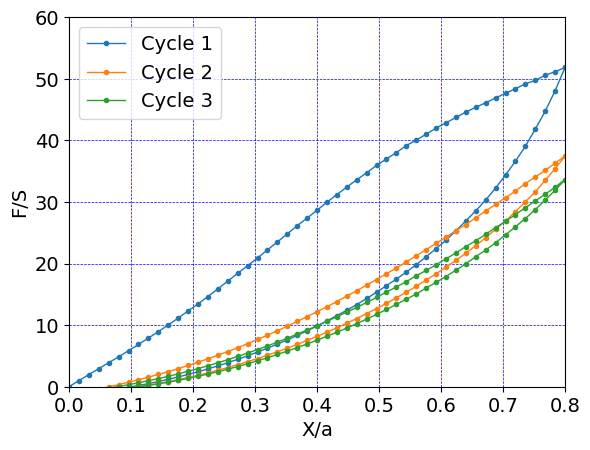

In [7]:
'''''''''''''''''''''
    VISUALIZATION
'''''''''''''''''''''
# set plot font to size 14
font = {'size'   : 14}
plt.rc('font', **font)

# Get array of default plot colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig = plt.figure()
ax=fig.gca()

for i in range(1, Ncycle+1):
    plt.plot(timeHist1[(i-1)*math.floor(numSteps/Ncycle):i*math.floor(numSteps/Ncycle)+1]/2/bead_radius, \
             timeHist0[(i-1)*math.floor(numSteps/Ncycle):i*math.floor(numSteps/Ncycle)+1]/bead_radius**2/np.pi, \
              linewidth=1.0, marker='.', label="Cycle {}".format(int(i)))
ax.set_xlabel("X/a",size=14)
ax.set_ylabel("F/S",size=14)
ax.grid(linestyle="--", linewidth=0.5, color='b')
ax.set_xlim(0,0.8)
ax.set_ylim(0, 60)

plt.legend()

savestring="results/OT_V8_G="+str(Gshear)+"_stiffen="+str(float(stiffen))\
            +"_Gneq="+str(float(Gneq_1))+"_tau="+str(float(tau_1))\
            +"_zeta="+str(float(zeta)) + "_heal="+str(float(heal)) + "_gradConst="+str(float(grad_const))\
            +"_width="+str(float(width))\
            +"_Ncyc="+str(float(Ncycle)) + "_steps="+str(float(numSteps))\
            +".png"
plt.savefig(savestring, dpi=600)